In [ ]:
!pip install fastparquet   
!pip install pandas
!pip install requests
!pip install matplotlib
!pip install scikit-learn


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replac


--- Fetching and Storing Full Portfolio Data ---
Fetching QQQ (full history)...
Successfully fetched and saved 417 records for QQQ to ticker_data_parquet/QQQ.parquet

✅ All available data fetched and stored as individual parquet files successfully!
Fetched tickers: ['QQQ']

--- Plotting Individual Ticker Performance (from parquet) ---


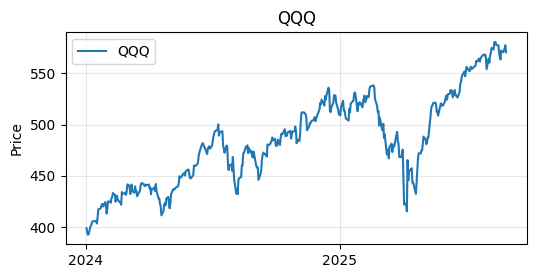


--- Data Fetching, Storing, and Plotting Complete ---


In [8]:
import pandas as pd
import requests
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json # Explicitly import json
import os # Import os to manage directories

# -------------------------------------------------------------
# Portfolio Configuration
# (Combines content from your previous Cell 2 and Cell 3)
# -------------------------------------------------------------
API_KEY = "1VWXIAX2LM6F6WV0" # Your Alpha Vantage API key
START_YEAR = 2024             # Filter data from this year onwards

TICKERS = [ "QQQ"
    # Nasdaq Top 20 (US Equities - Large Cap)
    # "NVDA", "MSFT", "AAPL", "GOOGL", "AMZN", "META", "TSLA", "AVGO", "TSM", "INTC",
    # "ADBE", "CMCSA", "CSCO", "PEP", "TXN", "PYPL", "QCOM", "AMGN", "GILD", "CHTR",

    # # Europe Top (European Equities - Broad/Large Cap)
    # "SAP", "ASML", "MC.PA", "RMS.PA", "OR.PA", "AZN", "VGK",

    # # Asia/Global Diversifiers (Asian Equities & Resources)
    # "XOM", "TSM", "TCEHY", "FXI", "EWY",

    # Crypto (from Alpha Vantage, use SYMBOL-USD format)
    # "BTC-USD", "ETH-USD"
]

# -------------------------------------------------------------
# Robust Data Fetching Function
# (Content from your previous working fetch_alpha_vantage_data_robust function)
# -------------------------------------------------------------
def fetch_alpha_vantage_data_robust(ticker: str, api_key: str, output_size: str = "full") -> pd.DataFrame | None:
    """
    Fetch daily OHLCV data from Alpha Vantage for a single ticker (adjusted for stocks).
    Handles both TIME_SERIES_DAILY_ADJUSTED for stocks and DIGITAL_CURRENCY_DAILY for crypto.
    """
    base_url = "https://www.alphavantage.co/query"
    df = None

    def print_common_msgs(j: dict, ticker: str) -> bool:
        """Prints common Alpha Vantage messages (Note, Error Message, etc.) and indicates if it's a failure."""
        is_failure = False
        for k in ("Note", "Error Message", "Information", "Message"):
            if k in j:
                print(f"{ticker}: {k}: {j[k]}")
                if k in ("Error Message", "Information", "Message") or "frequency" in j[k].lower():
                    is_failure = True
        return is_failure

    # Crypto data
    if ticker.endswith("-USD"):
        params = {
            "function": "DIGITAL_CURRENCY_DAILY",
            "symbol": ticker.split("-")[0],
            "market": "USD",
            "apikey": api_key,
        }
        try:
            r = requests.get(base_url, params=params, timeout=20)
            r.raise_for_status() # Raise HTTPError for bad responses (4xx or 5xx)
            j = r.json()
        except requests.exceptions.RequestException as e:
            print(f"Request failed for {ticker}: {e}")
            return None
        except json.JSONDecodeError:
            print(f"{ticker}: Response not JSON: {r.text[:200]}")
            return None

        if print_common_msgs(j, ticker):
            return None

        key = "Time Series (Digital Currency Daily)"
        if key not in j:
            print(f"{ticker}: missing '{key}' in response for crypto")
            return None

        ts = j[key]
        df = pd.DataFrame.from_dict(ts, orient="index").astype(float)
        df.index = pd.to_datetime(df.index)

        # Crypto close column is '4. close' based on your diagnostic
        close_col = "4. close"

        if close_col not in df.columns:
            print(f"{ticker}: close column not found in crypto payload. Available: {df.columns.tolist()}")
            return None

        df = df.rename(columns={close_col: "Close"})
        df = df[["Close", "1. open", "2. high", "3. low"]].sort_index() # Include Open, High, Low
        df = df.rename(columns={"1. open": "Open", "2. high": "High", "3. low": "Low"}) # Rename for consistency
        df["Ticker"] = ticker
        return df

    # Stock data (adjusted for splits)
    params = {
        "function": "TIME_SERIES_DAILY_ADJUSTED",
        "symbol": ticker,
        "outputsize": output_size,
        "apikey": api_key,
    }
    try:
        r = requests.get(base_url, params=params, timeout=20)
        r.raise_for_status() # Raise HTTPError for bad responses (4xx or 5xx)
        j = r.json()
    except requests.exceptions.RequestException as e:
        print(f"Request failed for {ticker}: {e}")
        return None
    except json.JSONDecodeError:
        print(f"{ticker}: Response not JSON: {r.text[:200]}")
        return None

    if print_common_msgs(j, ticker):
        return None

    # Accept either "Time Series (Daily Adjusted)" or "Time Series (Daily)" keys
    key = None
    if "Time Series (Daily Adjusted)" in j:
        key = "Time Series (Daily Adjusted)"
    elif "Time Series (Daily)" in j:
        key = "Time Series (Daily)"

    if key is None:
        print(f"{ticker}: no daily time series key present in response")
        return None

    ts = j[key]
    df = pd.DataFrame.from_dict(ts, orient="index").astype(float)
    df.index = pd.to_datetime(df.index)

    # Prefer adjusted close when available, else fallback to raw close
    close_col = None
    if "5. adjusted close" in df.columns:
        close_col = "5. adjusted close"
    elif "4. close" in df.columns:
        close_col = "4. close"

    if close_col is None:
        print(f"{ticker}: no close column found (expected '5. adjusted close' or '4. close'). Available: {df.columns.tolist()}")
        return None

    # Include '1. open', '2. high', '3. low' for stocks
    df = df.rename(columns={
        close_col: "Close",
        "1. open": "Open",
        "2. high": "High",
        "3. low": "Low",
        "6. volume": "Volume" # Include volume as well
    })
    # Select desired columns and ensure correct order
    df = df[["Open", "High", "Low", "Close", "Volume"]].sort_index()
    df["Ticker"] = ticker
    return df

# -------------------------------------------------------------
# Main Data Fetching and Storing Workflow
# -------------------------------------------------------------
print("\n--- Fetching and Storing Full Portfolio Data ---")
# Create a directory to store individual ticker data if it doesn't exist
output_dir = "ticker_data_parquet"
os.makedirs(output_dir, exist_ok=True)

fetched_tickers = []

for ticker in TICKERS:
    print(f"Fetching {ticker} (full history)...")
    # Using the robust fetcher with output_size='full'
    df = fetch_alpha_vantage_data_robust(ticker, API_KEY, output_size="full")

    if df is not None:
        # Filter from START_YEAR
        df = df[df.index.year >= START_YEAR]

        # Save individual ticker data to a parquet file
        file_path = os.path.join(output_dir, f"{ticker}.parquet")
        df.to_parquet(file_path)
        print(f"Successfully fetched and saved {len(df)} records for {ticker} to {file_path}")
        fetched_tickers.append(ticker)

        # Explicitly delete the DataFrame to free up memory
        del df

    time.sleep(12) # Respect Alpha Vantage API limit (5 requests/minute)

if not fetched_tickers:
    raise RuntimeError("No data was fetched for any ticker from Alpha Vantage. Please check API key, internet connection, or ticker symbols.")

print("\n✅ All available data fetched and stored as individual parquet files successfully!")
print(f"Fetched tickers: {fetched_tickers}")

# Note: The combined 'data' DataFrame is no longer created directly in memory.
# You will need to load data for analysis from the individual parquet files.

# -------------------------------------------------------------
# Plotting - Individual Ticker Performance (small multiples)
# (Modified to load data from parquet files)
# -------------------------------------------------------------
print("\n--- Plotting Individual Ticker Performance (from parquet) ---")
tickers_to_plot = fetched_tickers # Plot only the tickers for which data was fetched
n_plots = len(tickers_to_plot)

if n_plots > 0:
    # Determine grid size for subplots
    n_cols = 3 # You can adjust this for wider or narrower grids
    n_rows = (n_plots + n_cols - 1) // n_cols

    fig_multiples, axes_multiples = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3 * n_rows), sharex=True)
    axes_multiples = axes_multiples.flatten() # Flatten for easy iteration

    for i, ticker in enumerate(tickers_to_plot):
        ax = axes_multiples[i]
        file_path = os.path.join(output_dir, f"{ticker}.parquet")

        try:
            # Load data for the individual ticker from its parquet file
            ticker_data = pd.read_parquet(file_path)

            # Ensure unique index by grouping on Date if duplicates exist (shouldn't if data is clean)
            if not ticker_data.index.is_unique:
                ticker_data = ticker_data.groupby(ticker_data.index).mean(numeric_only=True)

            # Plot closing price, ensuring 'Close' column exists
            if 'Close' in ticker_data.columns:
                ax.plot(ticker_data.index, ticker_data['Close'], label=ticker, linewidth=1.5)
            else:
                print(f"⚠️ Warning: 'Close' column not found in parquet for {ticker}. Skipping individual plot.")
                continue

            # Formatting
            ax.set_title(ticker)
            ax.set_ylabel('Price')
            ax.grid(True, alpha=0.3)
            ax.legend(loc='upper left')

        except FileNotFoundError:
            print(f"⚠️ Warning: Parquet file not found for {ticker}. Skipping individual plot.")
            continue

    # Set common X-axis locators/formatters only on the bottom row for clarity
    for ax_row in axes_multiples.reshape(n_rows, n_cols)[-1]:
        ax_row.xaxis.set_major_locator(mdates.YearLocator())
        ax_row.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Hide any unused subplots
    for j in range(i + 1, len(axes_multiples)):
        fig_multiples.delaxes(axes_multiples[j])

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle
    plt.show()
else:
    print("No tickers to plot.")


print("\n--- Data Fetching, Storing, and Plotting Complete ---")

In [9]:
# In the previous cell, data is now saved as individual parquet files per ticker.
# Load individual ticker data and combine them into a single DataFrame.

all_data_frames = []
output_dir = "ticker_data_parquet"

# Iterate through the fetched tickers and load their parquet files
for ticker in fetched_tickers:
    file_path = os.path.join(output_dir, f"{ticker}.parquet")
    try:
        ticker_df = pd.read_parquet(file_path)
        all_data_frames.append(ticker_df)
    except FileNotFoundError:
        print(f"Warning: Parquet file not found for {ticker}. Skipping.")
        continue

if all_data_frames:
    # Combine all individual DataFrames into a single one
    data = pd.concat(all_data_frames)

    # Save the combined data to a Parquet file
    data.to_parquet("portfolio_data.parquet")
    print("Combined data saved to portfolio_data.parquet")

    # Load the data from the Parquet file to verify
    loaded_data = pd.read_parquet("portfolio_data.parquet")

    # Reorder columns to have 'Ticker' as the first column
    cols = ['Ticker'] + [col for col in loaded_data.columns if col != 'Ticker']
    loaded_data = loaded_data[cols]

    # Display the first few rows of the loaded data
    display(loaded_data.head())

else:
    print("No data frames were loaded to combine.")

Combined data saved to portfolio_data.parquet


,Ticker,Open,High,Low,Close,Volume
2024-01-02,QQQ,405.84,406.09,400.2400,399.190687,58026946.0
2024-01-03,QQQ,399.93,401.00,397.8900,394.966656,47002803.0
2024-01-04,QQQ,396.44,399.59,396.0600,392.933966,39432797.0
2024-01-05,QQQ,396.45,399.56,395.3400,393.399997,44742783.0
2024-01-08,QQQ,397.99,405.24,397.8399,401.530760,42473796.0


vectors, parquets, dask,

van hier uit, gewoon stap per stap de oude notebook opnieuw overnemen, het zou goed moeten kunnen, gewoon, ombouwen pretty much, logica dieper pakken, meteen op schaal gaan, meer documenteren, robustness test inbouwen etc. meteen

train / test data split voor in and out of sample,

rolling sharpe etc.

In [15]:
from sklearn.model_selection import train_test_split

# Split the data into features (X) and target (y). Assuming 'Close' is the target.
# You might need to adjust features based on your model's needs.
X = loaded_data.drop(columns=['Close', 'Ticker']) # Example: dropping 'Close' and 'Ticker' as features
y = loaded_data['Close']
tickers = loaded_data['Ticker'] # Keep track of tickers

# Split the data while maintaining the time series order.
# We will use the index (Date) to split the data.
# The split point will be 80% of the way through the sorted index.

# Sort the data by index (Date) to ensure proper time series splitting
loaded_data_sorted = loaded_data.sort_index()


# Calculate the split point index
split_index = int(len(loaded_data_sorted) * 0.8)


# Split the data based on the calculated index
train_data = loaded_data_sorted.iloc[:split_index]
test_data = loaded_data_sorted.iloc[split_index:]

print("Data split into training and testing sets.")
print(f"Training set shape: {train_data.shape}")
print(f"Testing set shape: {test_data.shape}")

display(train_data.head())
display(test_data.head())

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
import ta # Import the ta library

# Define ranges for the parameters for grid search or exploration
kama_length_range = [10, 20, 30]
kama_fast_range = [2, 5]
kama_slow_range = [20, 30, 50]

supertrend_length_range = [7, 14]
supertrend_multiplier_range = [2, 3.5]

# OBV can be analyzed with moving averages or standard deviations, though the core calculation is cumulative.
# Define parameters for OBV analysis if you plan to grid search on them (e.g., for an OBV moving average)
obv_vwma_length_range = [10, 20, 50] # Example: for a Volume-Weighted Moving Average of OBV
obv_std_length_range = [10, 20] # Example: for the standard deviation of OBV
obv_std_multiplier_range = [2, 3] # Example: for Bollinger Bands multiplier

# To apply these ranges, you would typically loop through the combinations
# or use a library like scikit-learn's GridSearchCV if you were building a model.
# For now, let's calculate the indicators using the first values in the ranges as an example.

# Define parameters using the first value in each range for demonstration
kama_length = kama_length_range[0]
kama_fast = kama_fast_range[0]
kama_slow = kama_slow_range[0]

supertrend_length = supertrend_length_range[0]
supertrend_multiplier = supertrend_multiplier_range[0]

# Example OBV parameters
obv_vwma_length = obv_vwma_length_range[0]
obv_std_length = obv_std_length_range[0]
obv_std_multiplier = obv_std_multiplier_range[0]


# Calculate Triple KAMA
# The 'ta' library's KAMA function is part of the volatility indicators.
# It's designed to be applied directly to a Series.
loaded_data['KAMA_1'] = loaded_data.groupby('Ticker')['Close'].transform(lambda x: ta.volatility.kama(x, length=kama_length))
loaded_data['KAMA_2'] = loaded_data.groupby('Ticker')['KAMA_1'].transform(lambda x: ta.volatility.kama(x, length=kama_length)) # Apply KAMA to KAMA_1
loaded_data['KAMA_3'] = loaded_data.groupby('Ticker')['KAMA_2'].transform(lambda x: ta.volatility.kama(x, length=kama_length)) # Apply KAMA to KAMA_2


# Calculate Supertrend
# The 'ta' library's Supertrend function is part of the trend indicators.
# It requires high, low, and close prices, along with length and multiplier.
supertrend_indicator = ta.trend.SuperTrend(high=loaded_data['High'], low=loaded_data['Low'], close=loaded_data['Close'], window=supertrend_length, constant=supertrend_multiplier)

# The Supertrend indicator in 'ta' returns two series: the Supertrend line and the direction.
loaded_data['SUPERT'] = supertrend_indicator.supertrend()
loaded_data['SUPERTd'] = supertrend_indicator.supertrend_indicator()


# Calculate OBV
# The 'ta' library's OBV function is part of the volume indicators.
# It requires close price and volume.
loaded_data['OBV'] = ta.volume.OnBalanceVolume(close=loaded_data['Close'], volume=loaded_data['Volume']).on_balance_volume()


# Calculate a Volume-Weighted Moving Average (VWMA) of OBV
# The 'ta' library does not have a built-in VWMA for an arbitrary series like OBV.
# We will use pandas to calculate a rolling VWMA on the OBV column, weighted by Volume.
# This calculation needs to be done per ticker.

def calculate_obv_vwma(df, length):
    # Calculate rolling sum of (OBV * Volume) and rolling sum of Volume
    sum_obv_vol = (df['OBV'] * df['Volume']).rolling(window=length).sum()
    sum_vol = df['Volume'].rolling(window=length).sum()
    # Calculate VWMA: sum(OBV * Volume) / sum(Volume)
    vwma = sum_obv_vol / sum_vol
    return vwma

loaded_data['OBV_VWMA'] = loaded_data.groupby('Ticker').apply(lambda x: calculate_obv_vwma(x, length=obv_vwma_length)).reset_index(level=0, drop=True)


# Calculate the Standard Deviation of OBV
# The 'ta' library has a volatility.stdev function, but it's often for price.
# We can use pandas rolling standard deviation on the OBV column.
loaded_data['OBV_STD'] = loaded_data.groupby('Ticker')['OBV'].transform(lambda x: x.rolling(window=obv_std_length).std())


# Optional: Calculate Upper and Lower Bands for OBV (like Bollinger Bands on OBV)
loaded_data['OBV_Upper_Band'] = loaded_data['OBV_VWMA'] + (loaded_data['OBV_STD'] * obv_std_multiplier)
loaded_data['OBV_Lower_Band'] = loaded_data['OBV_VWMA'] - (loaded_data['OBV_STD'] * obv_std_multiplier)


# Define Triple KAMA crossover buy rule
loaded_data['Buy_Signal_TripleKAMA'] = ((loaded_data['KAMA_1'] > loaded_data['KAMA_2']) &
                                        (loaded_data['KAMA_2'] > loaded_data['KAMA_3']) &
                                        (loaded_data['KAMA_1'].shift(1) <= loaded_data['KAMA_2'].shift(1)) &
                                        (loaded_data['KAMA_2'].shift(1) <= loaded_data['KAMA_3'].shift(1))
                                       ).astype(int)


# Display the data with the new technical indicators and buy signal
display(loaded_data.head())
display(loaded_data[['Close', 'KAMA_1', 'KAMA_2', 'KAMA_3', 'Buy_Signal_TripleKAMA', 'SUPERT', 'SUPERTd', 'OBV', 'OBV_VWMA', 'OBV_STD', 'OBV_Upper_Band', 'OBV_Lower_Band']].tail())

AttributeError: module 'ta.volatility' has no attribute 'kama'

# Task
Manually calculate Triple KAMA, Supertrend, OBV VWMA, and OBV Standard Deviation on the `loaded_data` DataFrame, define trading rules based on these indicators, and add the indicators and trading signals as new columns to the DataFrame.

## Manual obv calculation

### Subtask:
Calculate the On-Balance Volume (OBV) manually based on the close price and volume.


**Reasoning**:
The previous code block failed because the `ta` library does not have a KAMA function. I need to manually calculate the OBV for each ticker based on the provided instructions. I will initialize the 'OBV' column and then iterate through the DataFrame, applying the OBV logic for each ticker group.

